In [1]:
""" 
NOTEBOOK :  ntbk_figures_toy_data.ipynb 

This notebook produces the figures for the paper: 

 Boosting ensemble size of climate fields using generative machine learning; a proof of concept
  by P. Gooya, R. Sospedra-Alfonso, and J. Exenberger submitted to XXXX

STATUS  : Complete - needs checking results in full detail
COMMENTS: ...

"""""

' \nNOTEBOOK :  ntbk_figures_toy_data.ipynb \n\nThis notebook produces the figures for the paper: \n\n Boosting ensemble size of climate fields using generative machine learning; a proof of concept\n  by P. Gooya, R. Sospedra-Alfonso, and J. Exenberger submitted to XXXX\n\nSTATUS  : Complete - needs checking results in full detail\nCOMMENTS: ...\n\n'

In [ ]:
import os
import yaml 
import gc

filename = f'{os.getcwd()[:-10]}/config.yaml'
with open(filename) as f:
    dict_yaml = yaml.load(f, Loader=yaml.loader.SafeLoader)

var        = dict_yaml['variable'][0]
dir_source = dict_yaml['dir_source']
dict_toy   = dict_yaml['data_toy_info']
list_data  = dict_yaml['list_data_raw'] + dict_yaml['list_data_toy']
dir_frnt_out = dict_yaml['dir_frnt_out']


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(1, f'{dir_source}')

from modules.data_load      import load_toy_data
from modules.info_plt      import plt_module
from modules.plot_package   import plot_ts, plot_qq, plot_spectra
from modules.util_analysis  import get_variance, power
from modules.util_glbavg    import *

## Set Up ##

In [4]:
dict_toy_plt   = plt_module().dict_toy_plt

## Load Data ##

In [5]:
dict_data = load_toy_data(list_data,
                          dict_toy)

import random
dict_data['toy_cVAE2'] = dict_data['toy_cVAE2'].isel(realization = random.sample(range(0, 5000), 2000))


population
====


train_sample
====
toy_VAE1
====
toy_VAE2
====
toy_cVAE2
====
toy_cVAE1
====


In [6]:
idisplay = False
if idisplay:
    for idata in list_data:
        display(dict_data[idata])

## Figures ##

- Figure 1 - Panel: Variance

In [7]:
# analytical values go here

In [8]:
def get_variance(ds,
                 dim_var='realization', uncentered = False):
    # return (ds - ds.mean(dim_var)).var(dim=dim_var)
    if uncentered:
        return (ds**2).mean(dim_var) 
    else:
        return ds.var(dim=dim_var)

In [9]:
dict_var = {}
for idata in list_data:
    dict_var[idata] = area_weighted_avg(get_variance(dict_data[idata], uncentered = False)).stack(month=("year","time")).squeeze().astype('float32')
    # dict_var[idata] = area_weighted_avg(get_variance(dict_data[idata] , uncentered = True)).stack(month=("year","time")).squeeze().astype('float32')


In [10]:
from pathlib import Path
LOC_FORECASTS_fgco2 = '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/fgco2/simulation'
ds_train = xr.open_dataset(dict_toy['train_sample']['dir_in'] + '/'+ dict_toy['train_sample']['file_in'] + '.nc')
(t1, t2) = ds_train.fgco2.attrs['time_scales']
time = np.arange(len(ds_train.year) * 12)
del ds_train
a = 0.5 * (np.cos(4 * np.pi * time / t1) + np.cos(4 * np.pi * time / t2))
ecos2delta = np.exp(-2 )
e2cosdelta = np.exp(-0.5) ** 2

dict_var['theoritical'] = xr.full_like(dict_var['train_sample']['tas'], np.nan)
# dict_var['theoritical'][:] = (1 - ecos2delta*a )[-60:]   ### uncentered
dict_var['theoritical'][:] = (1 - ecos2delta*a - e2cosdelta*(1-a))[-60:]  ### Centered


dict_var['theoritical'] = dict_var['theoritical'].to_dataset()  

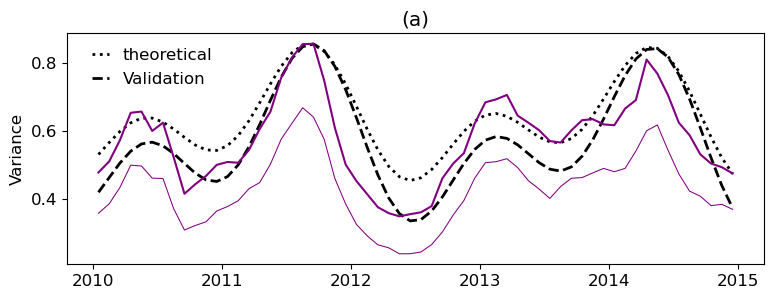

In [89]:
plot_ts(['theoritical','train_sample','toy_cVAE1' ,'toy_cVAE2' ],
# plot_ts(['theoritical' ],
        # plot_ts(['population','train_sample','toy_cVAE'],        
        # plot_ts(list_data, # including all kills the kernel
        dict_ds=dict_var,
        dict_plot=dict_toy_plt,
        xdim='year',
        ylabel = 'Variance',
        bbox=(-0.27,.5,.5,.5),
        figsize=(9,3),
        title=f'(a)',
        dir_name= dir_frnt_out,
        file_name= 'Figure1_a',
        show=True,
        save=True)

- Figure 1 - Panel: QQ map 

In [14]:
dict_anom = {}
for idata in list_data:
    dict_anom[idata] = dict_data[idata] - dict_data[idata].mean(dim='realization')
    if 'VAE' in idata:
        dict_anom[idata] = dict_anom[idata].where(dict_anom[idata] <= dict_anom['train_sample'].max() )  ### through out outliers
        dict_anom[idata] = dict_anom[idata].where(dict_anom[idata] >= dict_anom['train_sample'].min() ) ### through out outliers

In [15]:
quantiles = np.linspace(start=0, stop=1, num=int(100))[1:-1]

In [16]:
dict_quantiles_flat = {}
for idata in ['train_sample', 'population', 'toy_cVAE1','toy_cVAE2']:
# for idata in ['toy_cVAE2']:
    
    # dict_quantiles_flat[idata] = dict_anom[idata][var].to_numpy().flatten() # this kills the kernel
    ds1 = dict_anom[idata].tas.values.flatten()
    ds1 = ds1[~np.isnan(ds1)]
    ds1_quantiles = np.quantile(ds1, quantiles, interpolation='nearest') # interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
    dict_quantiles_flat[idata] = ds1_quantiles #ds2.stack(dim_y=("dim_t","dim_x")).chunk(dict(dim_y=-1))    

In [ ]:
idata_ref = 'train_sample'
# plot_qq([key for key in list_data if key != idata_ref],
plot_qq(['population','toy_VAE1', 'toy_VAE2'],
        dict_quantiles_flat,
        idata_ref=idata_ref,
        dict_plt=dict_toy_plt,
        box=[[-4,-4],
             [4,4]],
     figsize=(8,4),
        bbox=(-0.15,.5,.5,.5),
        xlabel='Reference Anomalies',
        ylabel='Anomalies',
        dir_name= dir_frnt_out,
        file_name= 'Figure1_b',
        title='(b)',
        show=True,
        save=True)


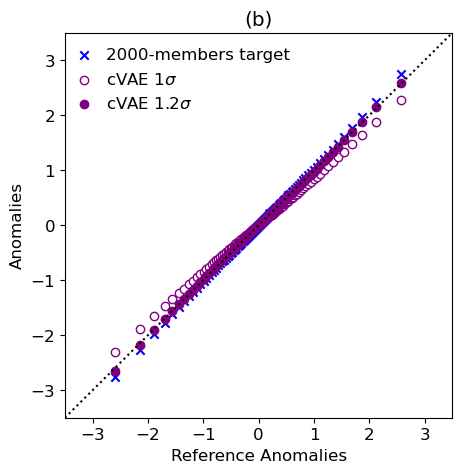

In [54]:
idata_ref = 'train_sample'
# plot_qq([key for key in list_data if key != idata_ref],
plot_qq(['population','toy_cVAE1', 'toy_cVAE2'],
        dict_quantiles_flat,
        idata_ref=idata_ref,
        dict_plt=dict_toy_plt,
        figsize=(5,5),
        box=[[-3.5,-3.5],
             [3.5,3.5]],
        bbox=(0.12,.5,.5,.5),
        xlabel='Reference Anomalies',
        ylabel='Anomalies',
          dir_name= dir_frnt_out,
        file_name= 'Figure1_b',
        title = '(b)',
        show=True,
        save=True)


- Figure S1

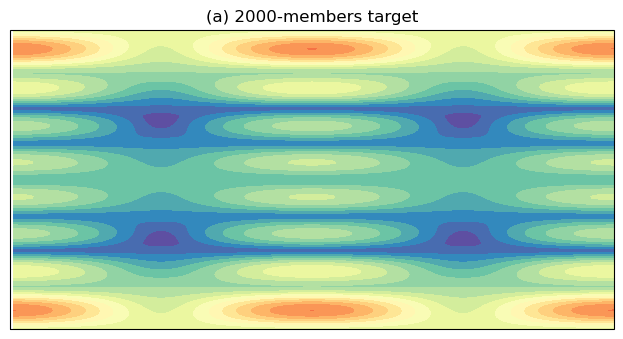

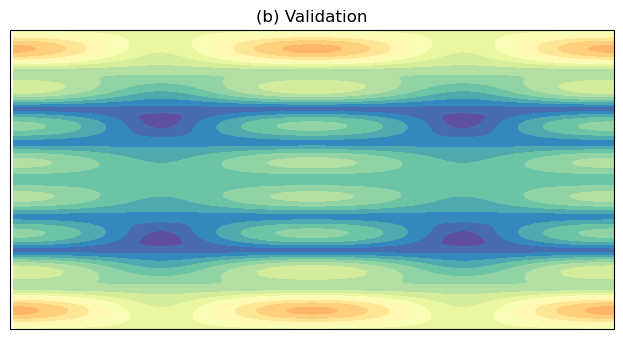

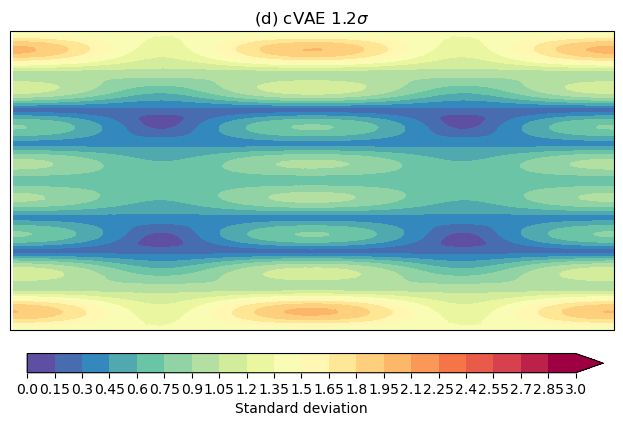

In [18]:
from modules.plot_package import plot_map
time_to_show = np.arange(1,13) #[1]

ds = dict_data['population'][var].sel(time=time_to_show).std(['realization']).mean(['year','time'])

plot_map(ds,
                title=f'(a) {dict_toy_plt["population"]["label"]}',
                    vmin=0,
                    vmax=3,
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=False,
                nvals = 20,
                fig_dir=f'{dir_frnt_out}',
                coastlines=False,
                fig_name=f'FigureS3_a',
                show=True,
                save=True)

ds = dict_data['train_sample'][var].sel(time=time_to_show).std(['realization']).mean(['year','time'])

plot_map(ds,
                title=f'(b) {dict_toy_plt["train_sample"]["label"]}',
                    vmin=0,
                    vmax=3,
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=False,
                nvals = 20,
                fig_dir=f'{dir_frnt_out}',
                coastlines=False,
                fig_name=f'FigureS3_b',
                show=True,
                save=True)


# ds = dict_data['toy_VAE2'][var].sel(time=time_to_show).std(['realization']).mean(['year','time'])

# plot_map(ds,
#                 title=f'(c) {dict_toy_plt["toy_VAE2"]["label"]}',
#                     vmin=0,
#                     vmax=3,
#                     cmap='Spectral_r',
#                     cbar_extend='max',
#                 cbar=True,
#                 nvals = 20,
#                 fig_dir=f'{dir_frnt_out}',
#                 fig_name=f'FigureS3_c_',
#                 coastlines=False,
#                 cbar_label = 'Standard deviation',
#                 show=True,
#                 save=True)

ds = dict_data['toy_cVAE2'][var].sel(time=time_to_show).std(['realization']).mean(['year','time'])

plot_map(ds,
                title=f'(d) {dict_toy_plt["toy_cVAE2"]["label"]}',
                    vmin=0,
                    vmax=3,
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=True,
                nvals = 20,
                fig_dir=f'{dir_frnt_out}',
                fig_name=f'FigureS3_c',
                coastlines=False,
                cbar_label = 'Standard deviation',
                show=True,
                save=True)

In [ ]:
# # from modules.plot_package import plot_map
# time_to_show = np.arange(1,13) #[1]

# ds1 = dict_data['population'][var].sel(time=time_to_show).std(['realization']).mean(['year','time'])


# ds2 = dict_data['train_sample'][var].sel(time=time_to_show).std(['realization']).mean(['year','time'])

# plot_map(ds2 - ds1,
#                 title=f'{dict_toy_plt["train_sample"]["label"]}',
#                     vmin=0,
#                     vmax=3,
#                     cmap='Spectral_r',
#                     cbar_extend='max',
#                 cbar=False,
#                 nvals = 20,
#                 fig_dir=f'{dir_frnt_out}',
#                 coastlines=False,
#                 fig_name=f'FigureS1_b',
#                 show=True,
#                 save=True)


# ds3 = dict_data['toy_VAE2'][var].sel(time=time_to_show).std(['realization']).mean(['year','time'])

# plot_map(ds3 - ds1,
#                 title=f'{dict_toy_plt["toy_VAE2"]["label"]}',
#                     vmin=0,
#                     vmax=3,
#                     cmap='Spectral_r',
#                     cbar_extend='max',
#                 cbar=False,
#                 nvals = 20,
#                 fig_dir=f'{dir_frnt_out}',
#                 fig_name=f'FigureS1_c',
#                 coastlines=False,
#                 cbar_label = 'Standard deviation',
#                 show=True,
#                 save=True)

# ds4 = dict_data['toy_cVAE2'][var].sel(time=time_to_show).std(['realization']).mean(['year','time'])

# plot_map(ds4 - ds1,
#                 title=f'{dict_toy_plt["toy_cVAE2"]["label"]}',
#                     vmin=0,
#                     vmax=3,
#                     cmap='Spectral_r',
#                     cbar_extend='max',
#                 cbar=True,
#                 nvals = 20,
#                 fig_dir=f'{dir_frnt_out}',
#                 fig_name=f'FigureS1_d',
#                 coastlines=False,
#                 cbar_label = 'Standard deviation',
#                 show=True,
#                 save=True)

# del ds4, ds1, ds2, ds3

- Figure 2 - Power Spectra

In [21]:
from tqdm import tqdm
time_to_show = 11
year_to_show = 2013

dict_spectra = {}
for idata in ['train_sample' ,'toy_cVAE2']:
    print(idata)
    ds = dict_data[idata].sel(year=year_to_show,
                              time=time_to_show).load()
    data_pwr = []
    data_wav = []
    for ii in tqdm(ds.realization.values):
        (spectrum,
         wavelengths_km) = power(ds[var].sel(realization=ii).sel(lon=ds.lon.values[:-1]))
        data_pwr.append(np.log2(spectrum))
        data_wav.append(wavelengths_km)
    del ds
        
    dict_spectra[idata] = {}
    dict_spectra[idata]['power']      =  np.array(data_pwr)   #np.load(f'{idata}_power.npy')
    dict_spectra[idata]['wavelength'] =  np.array(data_wav)   #np.load(f'{idata}_power.npy')


train_sample


100%|██████████| 20/20 [00:00<00:00, 409.56it/s]


toy_cVAE2


100%|██████████| 2000/2000 [00:04<00:00, 430.30it/s]


In [ ]:
# plot_spectra(dict_spectra,
#             #  ['train_sample'])
#              ['train_sample','toy_VAE2'],    
#              dict_plt_data=dict_toy_plt,            
#                dict_plt={'title'   : f' Power Spectra {year_to_show}-{np.divmod(time_to_show,10)[0]}{np.divmod(time_to_show,10)[1]}',
#                            'xlabel'  : 'Wavelength (km)',
#                            'ylabel'  : 'Log$_2$ Power',                       
#                            'legend' :
#                            {
#                             'ncol': 1,
#                             'pos' : (0,0),
#                             'loc' : 'lower left'}},
#                                     fig_dir= dir_frnt_out,
#                           fig_name= 'FigureS2_a',
#                           save = False,
#                            show = True)  # including both kills the kernel

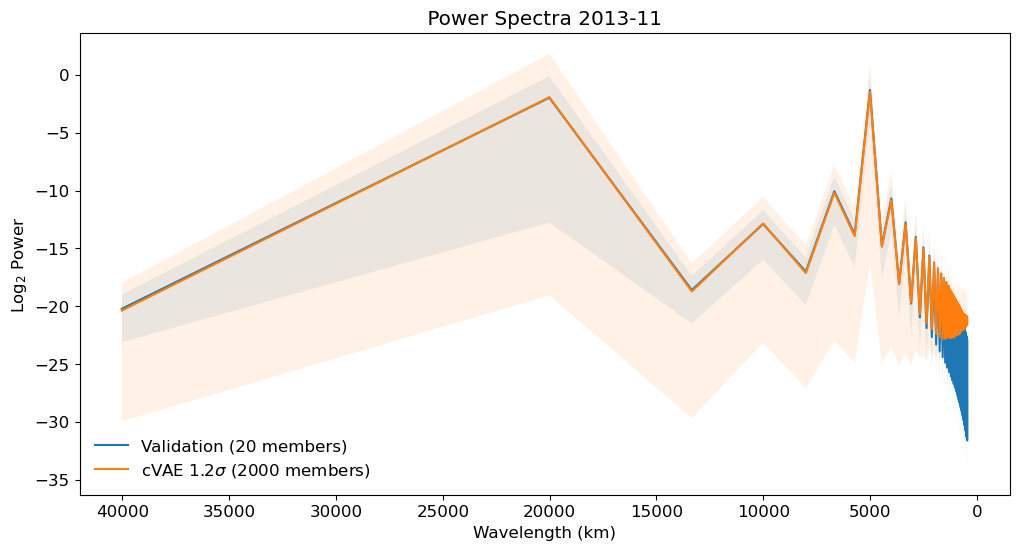

In [22]:
plot_spectra(dict_spectra,
            #  ['train_sample'])
             ['train_sample','toy_cVAE2'],    
             dict_plt_data=dict_toy_plt,                
               dict_plt={'title'   : f' Power Spectra {year_to_show}-{np.divmod(time_to_show,10)[0]}{np.divmod(time_to_show,10)[1]} ',
                           'xlabel'  : 'Wavelength (km)',
                           'ylabel'  : 'Log$_2$ Power',                       
                           'legend' :
                           {
                            'ncol': 1,
                            'pos' : (0,0),
                            'loc' : 'lower left'}},
                            fig_dir= dir_frnt_out,
                          fig_name= 'Figure2_a',
                          save = True,
                           show = True)  # including both kills the kernel

- Figure 2 - Panel: maps

In [ ]:
import matplotlib.pyplot as plt

time_to_show = 9
year_to_show = 2012
idata = 'population'

ds = dict_data[idata][var].sel(year = slice(year_to_show,year_to_show), time = time_to_show).load()

plt.figure(figsize = (50,50))
for ind, i in enumerate(range(0,200)):
    plt.subplot(15,15,ind+1)
    ds.isel(realization =5*i)[...,1:-1,1:-1].plot(vmin = -4, vmax = 4, cmap = 'RdBu_r')
del ds

In [ ]:
# import matplotlib.pyplot as plt

# time_to_show = 9
# year_to_show = 2012
# idata = 'toy_VAE2'


# plt.figure(figsize = (18,5))
# ds = dict_data[idata][var].sel(year = slice(year_to_show,year_to_show), time = time_to_show).load()

# for ind, i in enumerate([27*2,9*3,179]):
#     plt.subplot(1,3,ind + 1)

#     if ind == 0:
#         mesh = plt.pcolormesh(ds.lon, ds.lat, ds.isel(realization = i).squeeze(), vmin = -4, vmax = 4, cmap = 'RdBu_r')
#         plt.colorbar(mesh, extend='both')
#         plt.ylabel('lat', fontsize = 15)
#         plt.xlabel('')
#         plt.title('')
#     if ind == 1: 
#         mesh = plt.pcolormesh(ds.lon, ds.lat, ds.isel(realization = i).squeeze(), vmin = -3, vmax = 3, cmap = 'RdBu_r')
#         plt.colorbar(mesh, extend='both')
#         plt.ylabel('')
#         plt.xlabel('lon', fontsize = 15)
#         plt.title(f'{dict_toy_plt[idata]["label"]}', fontsize = 15)   
#     if ind == 2:
#         mesh = plt.pcolormesh(ds.lon, ds.lat, ds.isel(realization = i).squeeze(), vmin = -2, vmax = 2, cmap = 'RdBu_r')
#         plt.colorbar(mesh, extend='both')
#         plt.ylabel('')
#         plt.xlabel('')
#         plt.title('')

# Path(dir_frnt_out).mkdir(parents=True, exist_ok=True)
# plt.savefig(f'{dir_frnt_out}/FigureS2_bcd',
#             bbox_inches='tight',
#             dpi=300)
        
# del ds

In [ ]:
import matplotlib.pyplot as plt

time_to_show = 9
year_to_show = 2012
idata = 'toy_cVAE2'


plt.figure(figsize = (18,5))
ds = dict_data[idata][var].sel(year = slice(year_to_show,year_to_show), time = time_to_show).load()

for ind, i in enumerate([16*5,5, 123*2]):
    plt.subplot(1,3,ind + 1)
    

    if ind == 0:
        mesh = plt.pcolormesh(ds.lon, ds.lat, ds.isel(realization = i).squeeze(), vmin = -4, vmax = 4, cmap = 'RdBu_r')
        plt.colorbar(mesh, extend='both')
        plt.ylabel('lat', fontsize = 15)
        plt.xlabel('')
        plt.title('')
    if ind == 1: 
        mesh = plt.pcolormesh(ds.lon, ds.lat, ds.isel(realization = i).squeeze(), vmin = -3, vmax = 3, cmap = 'RdBu_r')
        plt.colorbar(mesh, extend='both')
        plt.ylabel('')
        plt.xlabel('lon', fontsize = 15)
        plt.title(f'{dict_toy_plt[idata]["label"]}', fontsize = 15)   
    if ind == 2:
        mesh = plt.pcolormesh(ds.lon, ds.lat, ds.isel(realization = i).squeeze(), vmin = -2, vmax = 2, cmap = 'RdBu_r')
        plt.colorbar(mesh, extend='both')
        plt.ylabel('')
        plt.xlabel('')
        plt.title('')

Path(dir_frnt_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_frnt_out}/Figure2_efg',
            bbox_inches='tight',
            dpi=300)
del ds

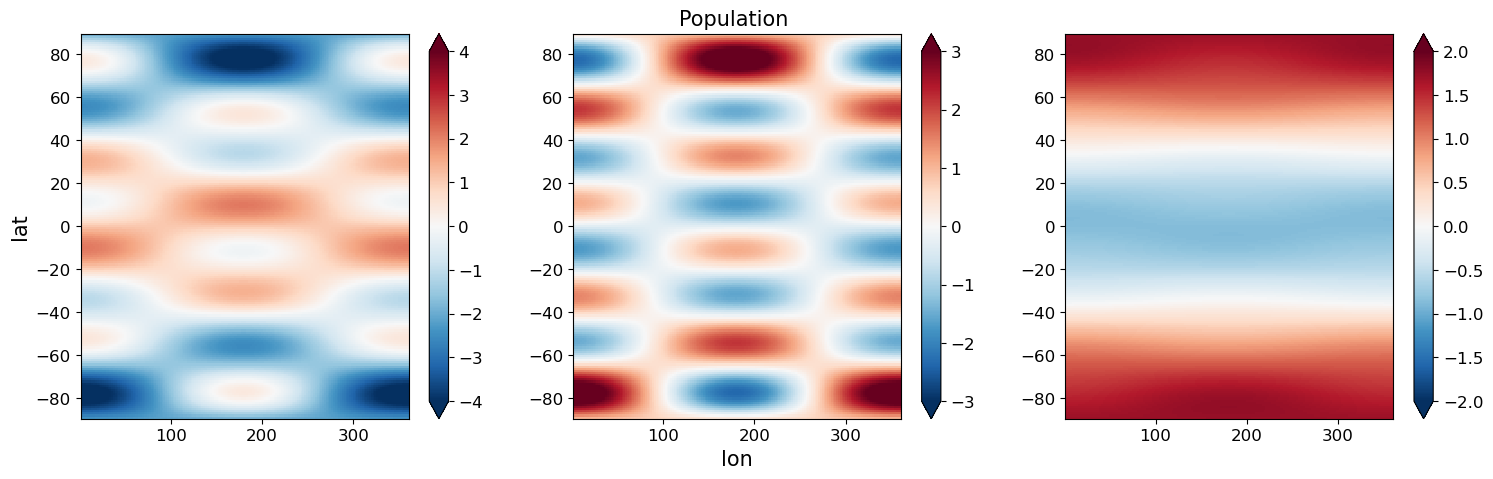

In [213]:
import matplotlib.pyplot as plt

time_to_show = 9
year_to_show = 2012
idata = 'population'


plt.figure(figsize = (18,5))
ds = dict_data[idata][var].sel(year = slice(year_to_show,year_to_show), time = time_to_show).load()

for ind, i in enumerate([130,84,210]):
    plt.subplot(1,3,ind + 1)
    

    if ind == 0:
        mesh = plt.pcolormesh(ds.lon, ds.lat, ds.isel(realization = i).squeeze(), vmin = -4, vmax = 4, cmap = 'RdBu_r')
        plt.colorbar(mesh, extend='both')
        plt.ylabel('lat', fontsize = 15)
        plt.xlabel('')
        plt.title('')
    if ind == 1: 
        mesh = plt.pcolormesh(ds.lon, ds.lat, ds.isel(realization = i).squeeze(), vmin = -3, vmax = 3, cmap = 'RdBu_r')
        plt.colorbar(mesh, extend='both')
        plt.ylabel('')
        plt.xlabel('lon', fontsize = 15)
        plt.title(f'{dict_toy_plt[idata]["label"]} ', fontsize = 15)   
    if ind == 2:
        mesh = plt.pcolormesh(ds.lon, ds.lat, ds.isel(realization = i).squeeze(), vmin = -2, vmax = 2, cmap = 'RdBu_r')
        plt.colorbar(mesh, extend='both')
        plt.ylabel('')
        plt.xlabel('')
        plt.title('')

Path(dir_frnt_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_frnt_out}/Figure2_bcd',
            bbox_inches='tight',
            dpi=300)
del ds

- Figure 1 - Panel: Latent space

In [10]:
from modules.util_latent import extract_latent_space_toy, prepare_data_for_AE_toy
model_year = 2012
idata = 'toy_cVAE2'

model_dir = dict_toy[idata]['dir_in'].split('/tests')[0]
data_dir = dict_toy['train_sample']['dir_in'] + '/'+ dict_toy['train_sample']['file_in'] + '.nc' 
ds_in = xr.open_dataset(data_dir).load()['fgco2']
ds_in = ds_in.expand_dims('channels', axis=3).sortby('ensembles')  


ds_train, ds_train_conds, params = prepare_data_for_AE_toy(ds_in, model_dir, model_year)


In [11]:
ds_mu, ds_samples, ds_emb, ds_mu_cond, ds_var_cond, net, params =  extract_latent_space_toy(ds_train, ds_train_conds, params )

loading model ...


Autoencoder(
  (condition_mu): Linear(in_features=1500, out_features=2, bias=True)
  (condition_log_var): Linear(in_features=1500, out_features=2, bias=True)
  (embedding): Sequential(
    (0): Linear(in_features=33489, out_features=1500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=1500, out_features=1500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=1500, out_features=1500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0, inplace=False)
    (9): Linear(in_features=1500, out_features=1500, bias=True)
    (10): ReLU()
    (11): Dropout(p=0, inplace=False)
    (12): Linear(in_features=1500, out_features=1500, bias=True)
    (13): ReLU()
    (14): Dropout(p=0, inplace=False)
    (15): Linear(in_features=1500, out_features=1500, bias=True)
    (16): ReLU()
    (17): Dropout(p=0, inplace=False)
    (18): Linear(in_features=1500, out_features=1500, bias=True)
    (19): ReLU()
    (20): Dropout(p=0,

In [13]:
from pathlib import Path

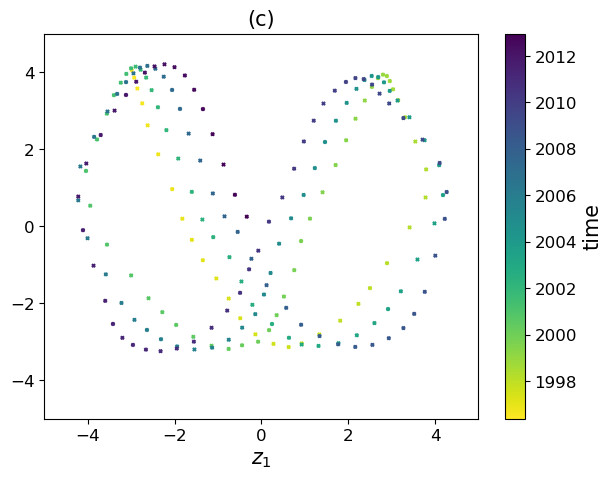

In [114]:
data = ds_mu # ds_samples
import matplotlib.pyplot as plt

plt.figure(figsize = (7,5))
ensemble_id = 3


x = data[-200:,ensemble_id,0].values
y = data[-200:,ensemble_id,1].values
z = data.year.values[-200:] + (data.lead_time.values[-200:] - 0.5) /12
scatter = plt.scatter(x,y ,c=z, cmap='viridis_r', marker = 'x', s = 5)
c = plt.colorbar(scatter)
c.set_label('time', fontsize = 15)
plt.xlabel('$z_{1}$', fontsize = 15)
# plt.ylabel('$z_{2}$', fontsize = 15)
plt.title(f'(c)', fontsize = 15
            )
plt.xlim(-5, 5)
plt.ylim(-5, 5)

Path(dir_frnt_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_frnt_out}/Figure1_c',
            bbox_inches='tight',
            dpi=300)

In [14]:
from modules.util_latent import generate_sin_phase_space_and_latent_encoding

if 'normal_pi' in data_dir:
    pi_normal = True
else:
    pi_normal = False
x_out, sin_phase_LE  = generate_sin_phase_space_and_latent_encoding(ds_in, params, net, num_members = 50, pi_normal = pi_normal )

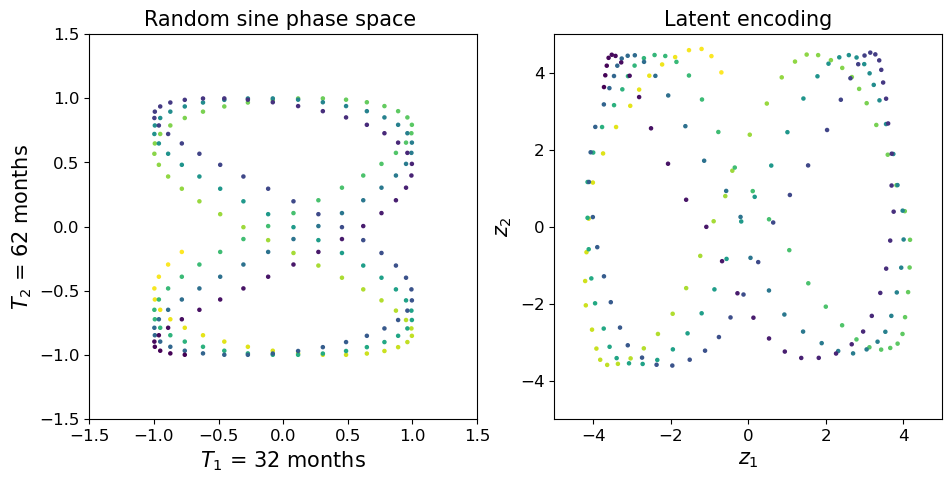

In [ ]:
ensemble_id = 11


x1 = sin_phase_LE[ensemble_id,-200:,0]
y1 = sin_phase_LE[ensemble_id,-200:,1]
x2 = x_out[ensemble_id,-200:,0]
y2 = x_out[ensemble_id,-200:,1]
values = ds_mu.year.values[-200:] + (ds_mu.lead_time.values[-200:] - 0.5) /12

# Initialize the plot
fig, ax = plt.subplots(1,2, figsize = (11,5))
scat1 = ax[0].scatter(x1, y1, c=values, cmap='viridis_r', s=5, vmin=values.min(), vmax=values.max())
ax[0].set_xlim(-1.5, 1.5)
ax[0].set_ylim(-1.5, 1.5)
ax[0].set_title('Random sine phase space ', fontsize = 15)
ax[0].set_xlabel('$T_{1}$ = 32 months', fontsize = 15)
ax[0].set_ylabel('$T_{2}$ = 62 months', fontsize = 15)

scat2 = ax[1].scatter(x2, y2, c=values, cmap='viridis_r', s=5, vmin=values.min(), vmax=values.max())
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)
# cbar2 = plt.colorbar(scat2, ax=ax[1])
# cbar2.set_label('year')
ax[1].set_title('Latent encoding', fontsize = 15)

plt.xlabel('$z_{1}$', fontsize = 15)
plt.ylabel('$z_{2}$', fontsize = 15)

# Path(dir_frnt_out).mkdir(parents=True, exist_ok=True)
# plt.savefig(f'{dir_frnt_out}/Figure1_de',
#             bbox_inches='tight',
#             dpi=300)

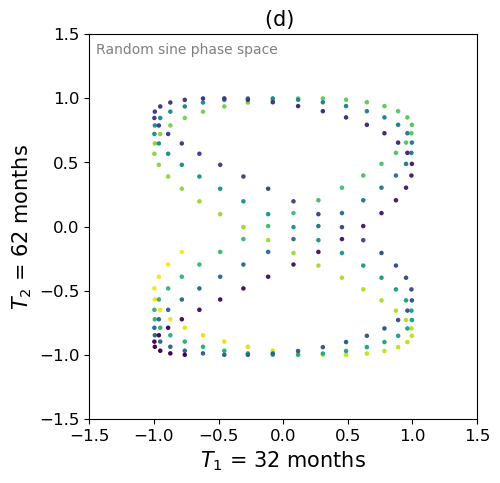

In [103]:

# Initialize the plot
fig, ax = plt.subplots(1,1, figsize = (5,5))
scat1 = ax.scatter(x1, y1, c=values, cmap='viridis_r', s=5, vmin=values.min(), vmax=values.max())
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_title('(d) ', fontsize = 15)
ax.set_xlabel('$T_{1}$ = 32 months', fontsize = 15)
ax.set_ylabel('$T_{2}$ = 62 months', fontsize = 15)

plt.text(-1.45,1.35, 'Random sine phase space', fontsize = 10, alpha = 0.5)


Path(dir_frnt_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_frnt_out}/Figure1_d',
            bbox_inches='tight',
            dpi=300)

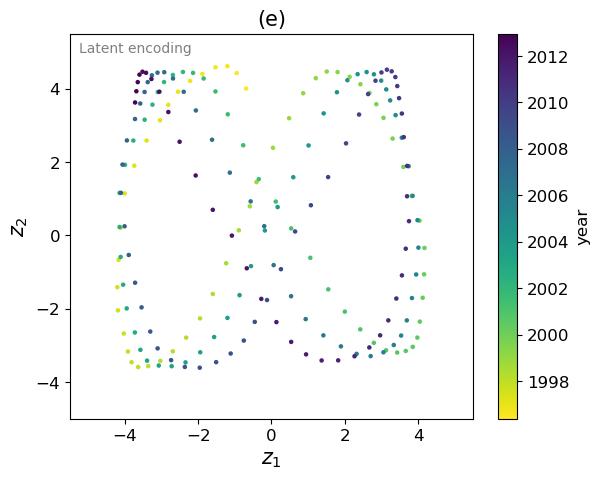

In [115]:
fig, ax = plt.subplots(1,1, figsize = (6.5,5))

scat2 = ax.scatter(x2, y2, c=values, cmap='viridis_r', s=5, vmin=values.min(), vmax=values.max())
ax.set_xlim(-5.5, 5.5)
ax.set_ylim(-5, 5.5)
cbar2 = plt.colorbar(scat2, ax=ax)
cbar2.set_label('year')
ax.set_title('(e)', fontsize = 15)

plt.text(-5.25,5, 'Latent encoding', fontsize = 10, alpha = 0.5)

plt.xlabel('$z_{1}$', fontsize = 15)
plt.ylabel('$z_{2}$', fontsize = 15)
Path(dir_frnt_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_frnt_out}/Figure1_e',
            bbox_inches='tight',
            dpi=300)

### Test with theoretical solution

In [45]:
def normal_samples_within_bounds(mean, cov, num_samples, bounds=(-1, 1)):
    samples = []
    while len(samples) < num_samples:
        # Generate a sample from a multivariate normal distribution
        sample = np.random.multivariate_normal(mean, cov)
        # Check if the sample lies within the specified bounds
        if np.all(sample >= bounds[0]) and np.all(sample <= bounds[1]):
            samples.append(sample)
    return np.array(samples)



data_dir = dict_toy['train_sample']['dir_in'] + '/'+ dict_toy['train_sample']['file_in'] + '.nc' 
ds_in = xr.open_dataset(data_dir).load()['fgco2']
time = np.arange(len(ds_in.year) * len(ds_in.lead_time))
harmonic_wavenumbers = ds_in.attrs['Spherical_harmonic_wavenumbers']
harmonic_m = ds_in.attrs['Spherical_harmonic_order']
freq_coeffs = ds_in.attrs['time_scales']
pi_normal = False

In [57]:
num_samples= 100
s = normal_samples_within_bounds(np.zeros(len(freq_coeffs)), np.identity(len(freq_coeffs)), num_samples, bounds=(-np.inf, np.inf)).squeeze()
target_ens = []

import pyshtools as pysh
for e in range(num_samples):
    ds_ls = []

    for t in time[:]:
        if pi_normal:
            sin_phase =  np.sin((t * 2 * np.pi / freq_coeffs) +  np.pi * s[e])
        else:
            sin_phase =  np.sin((t * 2 * np.pi / freq_coeffs) +   s[e])
        combined_coeffs = pysh.SHCoeffs.from_zeros(90)
        for ind, hv in enumerate(harmonic_wavenumbers):
            
            coeffs = pysh.SHCoeffs.from_zeros(90)
            coeffs.coeffs[0, hv, harmonic_m[ind]] = sin_phase[ind] 
            combined_coeffs += coeffs

        combined_grid = combined_coeffs.expand(grid='DH')
        ds_ls.append(xr.DataArray(
                                combined_grid.data,
                                dims=["lat", "lon"],  # Define the dimensions
                                coords={"lat": combined_grid.lats() , "lon": combined_grid.lons()},
                                name = 'fgco2'))
                                

    target_ens.append(xr.concat(ds_ls, dim = 'time'))


maps_LE = xr.concat(target_ens, dim = 'ensembles')


In [58]:
samples = s
(t1,t2) = freq_coeffs
a = 4 * np.pi * time[:,None] / np.array([t1,t2])


ls = []
alpha_list = []
beta_list = []
gama_list = []

alpha = 0.5 * (np.var(np.sin(samples), 0) + np.var(np.cos(samples), 0))
beta = 0.5 * (np.var(np.sin(samples), 0) - np.var(np.cos(samples), 0))
# gama =  - np.mean(np.sin(samples),0) * np.mean(np.cos(samples),0) + np.mean(np.sin(2*samples),0)  ##
gama =  - np.mean(np.sin(samples),0) * np.mean(np.cos(samples),0) + 0.5 * np.mean(np.sin(2*samples),0) 
alpha_list.append(alpha)
beta_list.append(beta)
gama_list.append(gama)
ds = (alpha + beta * np.cos(a) + gama * np.sin(a)).sum(1)


In [ ]:
# a = 0.5 * (np.cos(4 * np.pi * time / t1) + np.cos(4 * np.pi * time / t2))
# e2cosdelta = np.exp(-0.5 ) ** 2 
# ds_infinite = (1 - e2cosdelta) * (1 + e2cosdelta * a )


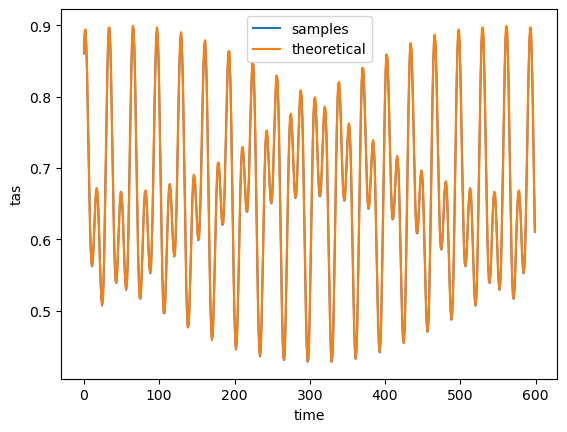

In [59]:
import matplotlib.pyplot as plt
ds_samples = area_weighted_avg(get_variance(maps_LE[...,:-1,:-1], 'ensembles').to_dataset(name = 'tas')).tas
ds_samples.plot(label = 'samples')
ds_theorerical = xr.full_like(ds_samples, fill_value=np.nan)
ds_theorerical[:] = ds
ds_theorerical.plot(label = 'theoretical')

# (ds_samples/ds_theorerical ).plot()
plt.legend()